# MNIST Multi-label Classification: Digit & Odd

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets as dts

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## One-hot encoding and add 1 if odd digit, 0 if even digit

In [2]:
from numpy import append, nonzero

trans = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

ytrans = transforms.Compose([
    # One Hot
    transforms.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)),

    # Add 1 if odd
    transforms.Lambda(lambda y: torch.cat((y, torch.Tensor([0]))) if y.nonzero().item() % 2 == 0 else torch.cat((y, torch.Tensor([1]))))
])

In [3]:
mnist_train_set = dts.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=trans,
    target_transform=ytrans
)

# Add the new label for odd numbers
mnist_train_set.classes.append('10 - odd')

mnist_test_set = dts.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=trans,
    target_transform=ytrans
)

## Plot the Digit & if Odd:1

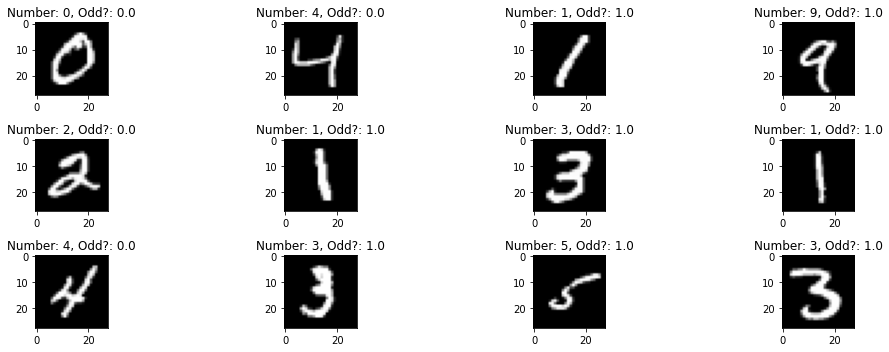

In [4]:
from re import I
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))
cols, rows = 4, 3
for i in range(1, cols * rows + 1):
    # plt.subplot(1, 3, 1 + int(i))
    fig.add_subplot(rows, cols, i)
    plt.tight_layout()
    tensor_image = mnist_train_set[i][0]
    plt.imshow(tensor_image.permute(1, 2, 0), cmap="gray"  )
    plt.title(f"Number: {mnist_train_set.targets[i]}, Odd?: {mnist_train_set[i][1][-1].item()}")
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=10, shuffle=True)

# Model - Simple CNN Network

In [6]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(         
            nn.Conv2d(1,16,5,1,2),                              
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )

        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )

        # fully connected layer, output 11 classes
        self.out = nn.Linear(32 * 7 * 7, 11)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

## Loss: BCEWithLogitsLoss

In [7]:
from torch import optim

model = CNN()
loss_func = nn.BCEWithLogitsLoss() 
# loss_func = nn.BCELoss()
# loss_func = nn.CrossEntropyLoss()   
optimizer = optim.Adam(model.parameters(), lr = 0.01)

if torch.cuda.is_available():
    model.cuda()


# Train

In [13]:
import numpy as np
from sklearn.metrics import accuracy_score

num_epochs = 10

correct = 0.
total = 0.

for epoch in range(num_epochs):
    train_loss = 0.0

    for data, labels in train_loader:
        
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        out = model(data)
        loss = loss_func(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # *** VALIDATION ***
    valid_loss = 0.0
    model.eval() 
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        out = model(data)

        #map preds to range of 0-1 and round
        preds = torch.sigmoid(out)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0

        #calculate how many labels were correctly classified
        total += labels.numel()
        correct += (preds == labels).sum().item()
        
        loss = loss_func(out, labels)
        valid_loss += loss.item()

    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1} \t Train Loss: {train_loss / len(train_loader)} \t Test Loss: {valid_loss / len(test_loader)} \t Test Acc: {accuracy}')

Epoch 1 	 Train Loss: 0.03527714501359666 	 Test Loss: 0.03485547369852429 	 Test Acc: 98.92363636363636
Epoch 2 	 Train Loss: 0.03647151276095739 	 Test Loss: 0.03947338181144733 	 Test Acc: 98.86863636363637
Epoch 3 	 Train Loss: 0.035471124141238305 	 Test Loss: 0.04147362722808612 	 Test Acc: 98.8190909090909
Epoch 4 	 Train Loss: 0.035135524345445444 	 Test Loss: 0.03284933783796441 	 Test Acc: 98.83590909090908
Epoch 5 	 Train Loss: 0.035601257894585465 	 Test Loss: 0.029844463329398423 	 Test Acc: 98.88545454545455
Epoch 6 	 Train Loss: 0.03550796810438836 	 Test Loss: 0.034482791628019184 	 Test Acc: 98.89424242424242
Epoch 7 	 Train Loss: 0.0357742545212133 	 Test Loss: 0.034947085970146875 	 Test Acc: 98.89545454545454
Epoch 8 	 Train Loss: 0.03493422341912052 	 Test Loss: 0.03660171280053328 	 Test Acc: 98.88556818181819
Epoch 9 	 Train Loss: 0.035224707850023455 	 Test Loss: 0.0357552638371526 	 Test Acc: 98.89626262626263
Epoch 10 	 Train Loss: 0.03537553703474623 	 Test L

## Batch Testing

In [14]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.cuda()

preds = model(images)
preds = torch.sigmoid(preds)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

print("Batch Accuracy: ", accuracy_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy()))

Batch Accuracy:  0.9


In [15]:
preds

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]], device='cuda:0',
       grad_fn=<IndexPutBackward0>)

In [16]:
labels

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]])